Connected to geo (Python 3.10.12)

In [1]:
run = 'f2_'
# f1 varios filtros, only L8 e L9, break em 2017
#   f1 salvando em float32

# f2 = f1 + landsat 5 e 7
#  tentar try except:

farm_file = '/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/CAR.gpkg'
folder_nc = farm_file.split('CAR.gpkg')[0] + f'nc/{run}/'
print(folder_nc)

import os
import boto3
import rasterio as rio
from pystac_client import Client
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
from datetime import date, datetime

from utils import *
import matplotlib.pyplot as plt

# Set environment and create AWS Session
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
os.environ['AWS_REQUEST_PAYER'] = 'requester'

print("Creating AWS Session")
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)
print(aws_session)

# open Farm
farm = gpd.read_file(farm_file, layer='AREA_IMOVEL_1')
bbox = get_bbox(farm)

#  Satellite imagery query params
today = date.today()
datetime_rangefull = str(f"2023-06-20/{str(today)}") #break  2017
max_cloud = 100
#bucketname = 'sanca'
satellite = 'Landsat'

/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f2_/
Creating AWS Session


In [2]:
URL = 'https://landsatlook.usgs.gov/stac-server'
cat = Client.open(URL)
collection_id = 'landsat-c2l2-sr'
collection = cat.get_collection(collection_id)
print(collection)

query_params = {
        "eo:cloud_cover": {"lt": max_cloud},
        "platform": {"in": ["LANDSAT_5","LANDSAT_7","LANDSAT_8", "LANDSAT_9"]},
       "landsat:collection_category": { "in": ['T1']}
                }

assets = ['red', 'blue', 'nir08', 'swir16' ] #'green', 'qa_pixel'

y0 = datetime.strptime(datetime_rangefull.split('/')[0],'%Y-%m-%d').year
yf = datetime.strptime(datetime_rangefull.split('/')[1],'%Y-%m-%d').year
m0 = str(datetime.strptime(datetime_rangefull.split('/')[0],'%Y-%m-%d').month).zfill(2)
mf = str(datetime.strptime(datetime_rangefull.split('/')[1],'%Y-%m-%d').month).zfill(2)
d0 = str(datetime.strptime(datetime_rangefull.split('/')[0],'%Y-%m-%d').day).zfill(2)
df = str(datetime.strptime(datetime_rangefull.split('/')[1],'%Y-%m-%d').day).zfill(2)

<CollectionClient id=landsat-c2l2-sr>


In [3]:
Path(folder_nc).mkdir( parents = True, exist_ok = True)
for ano in range(y0,yf):
    '''
        TODO falta um globals aqui pra player com os dados
    '''

    datetime_range = f'{ano}-{m0}-{d0}/{ano+1}-{m0}-{d0}'
    if yf == (ano+1):
        datetime_range = f'{ano}-{m0}-{d0}/{ano+1}-{mf}-{df}'
    print(ano, datetime_range)

    datetime_range_name = datetime_range.replace('/','_')

    try:
        ds = get_cube(datetime_range, 
                                        cat, 
                                        collection_id, 
                                        bbox, 
                                        query_params, 
                                        aws_session, assets)
        ds = dropper( ds , sat = satellite ) 

        # é aqui que a filtragem acontece
        ds2 = ds.copy()

        # valores extremos 
        ds2 = xr.where(ds2 > 40000, np.nan, ds2)
        ds2 = xr.where(ds2 < 5000, np.nan, ds2)
        for asset in assets:
            quantiles = [0.01,0.1,0.25,0.5,0.75,0.9,0.99]
            print(asset)
            print(quantiles)
            print(np.nanquantile(ds2[asset],quantiles))
            ds2[asset] = xr.where(ds2[asset] < np.nanquantile(ds2[asset],[0.01]), np.nan, ds2[asset])
            ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.99]), np.nan, ds2[asset])
            if asset == 'blue':
                ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.76]), np.nan, ds2[asset])
        
        # interpolate_na
        ds2 = ds2.chunk(dict(time=-1))
        ds2 = ds2.interpolate_na(dim="time",
                method='linear',
                use_coordinate=True, 
            ) 

        # rolling
        w = 3
        ds2 = ds2.rolling(time=w, center=True).mean(skipna=True)


        # REPROJECTION
        print(f'reprojecting cube for {datetime_range}')
        ds2 = ds2.rio.write_crs('epsg:4326')
        ds2 = ds2.rio.reproject('EPSG:4326')
        ds2 = ds2.rename({'x': 'longitude','y': 'latitude'})
        print('reprojecting... done')


        # CALCULATE indices
        ndvi = NDVI( ds2 )
        bsi= BSI( ds2 )

        # get dates to save exact name
        t0 = str(ndvi.time[0].values).split('T')[0]
        t1 = str(ndvi.time[0].values).split('T')[0]
        n = len(ndvi.time)
        try:
            ndvi = dropper(ndvi, 'Landsat')
            bsi = dropper(bsi, 'Landsat')
        except:
            print('not dropping, probably wont save')
        # save nc
        ndvi.to_netcdf(f'{folder_nc}/ndvi_{t0}-{t1}_{n}.nc')
        print('> ndvi saved')
        bsi.to_netcdf(f'{folder_nc}/bsi_{t0}-{t1}_{n}.nc.nc')
        print('> bsi saved') 

        # # CALCULATE climatology
        # ndvi_mean, ndvi_std = climatology(ndvi)
        # bsi_mean, bsi_std = climatology(bsi)

        # # CALCULATE Zscore and anomalies
        # ndvi_anom, ndvi_z = zscore( ndvi, 
        #                         how = 'month')
        # bsi_anom, bsi_z = zscore( bsi, 
        #                         how = 'month')

    except:
        print(f'{datetime_range} FAILED')

# # # %%
# # ndvi.clip(0,1000)
# # # %% TEMOS UM ds


# #%% a copy
# ds2 = ds.copy(deep=True)

# for asset in assets:
#     plt.hist(np.ravel(ds2[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

# ts = ds2.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')
# for asset in assets:
#     plt.plot(ts[asset].values, label = asset)

# #%% filta os principais outliers
# ds2 = ds.copy(deep=True)
# ds2 = xr.where(ds2 > 40000, np.nan, ds2)
# ds2 = xr.where(ds2 < 5000, np.nan, ds2)

# for asset in assets:
#     quantiles = [0.01,0.1,0.25,0.5,0.75,0.9,0.99]
#     print(quantiles)
#     print(np.nanquantile(ds2[asset],quantiles))
#     ds2[asset] = xr.where(ds2[asset] < np.nanquantile(ds2[asset],[0.01]), np.nan, ds2[asset])
#     ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.99]), np.nan, ds2[asset])
#     if asset == 'blue':
#         ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.76]), np.nan, ds2[asset])
#         #ds2[asset] = xr.where(ds2[asset] < np.nanquantile(ds2[asset],[0.01]), np.nan, ds2[asset])
#     plt.hist((np).ravel(ds2[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

# # farm.centroid
# ts2 = ds2.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')
# for asset in assets:
#     plt.plot(ts2[asset].values, label = asset)
# plt.legend()
# plt.grid()


# # %% 
# #f -> Interpolate NaN
# #ds3 = ds2.copy()
# method = 'linear'
# ds3 = ds2.interpolate_na(dim="time",
#             method=method,
#             use_coordinate=True, 
#         ) # pchip  # limit = 7, use_coordinate=True,


# ts3 = ds3.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')

# for asset in assets:
#     plt.plot(ts3[asset].values, label = asset)
# plt.grid();plt.show();plt.close()

# for asset in assets:
#     plt.hist(np.ravel(ds3[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

# # %% 
# # f -> rolling
# w = 3
# ds4 = ds3.rolling(time=w, center=True).mean(skipna=True)#savgol_filter, window=w, polyorder=2
# ts4 = ds4.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')

# for asset in assets:
#     plt.plot(ts4[asset].values, label = asset)
    
# plt.grid();plt.show();plt.close()

# for asset in assets:
#     plt.hist(np.ravel(ds4[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()
# # %% 
# for asset in assets:
#     plt.hist(np.ravel(ds4[asset].values), bins = 100)
#     plt.title(asset)
#     plt.show(); plt.close()
# ts2 = ds3.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')

# for asset in assets:
#     plt.plot(ts2[asset].values, label = asset)
# plt.legend()
# plt.grid()

# for asset in assets:
#     plt.hist(np.ravel(ds4[asset].values), bins = 100)
#     plt.title(asset)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

2023 2023-06-20/2024-05-08
50 items found 
 ---


/home/mariano/geo/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<<< landsat:correction dropped
<<< landsat:wrs_path dropped
<<< landsat:wrs_row dropped
<<< landsat:cloud_cover_land dropped
<<< landsat:collection_number dropped
<<< landsat:wrs_type dropped
<<< instruments dropped
--- raster:bands was not here
<<< eo:cloud_cover dropped
spec attribute deleted
red
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[ 7764.   8615.   9259.  10602.  12904.  18632.4 34775. ]
blue
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[ 7410.    7991.    8252.    8743.    9764.   17569.8  36925.18]
nir08
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[10697.   14874.5  17221.   19464.   21846.75 26004.   38845.  ]
swir16
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[ 8549.  11952.  13573.  15312.  17759.  20324.5 30644.8]
reprojecting cube for 2023-06-20/2024-05-08
reprojecting... done
--- landsat:correction was not here
--- landsat:wrs_path was not here
--- landsat:wrs_row was not here
--- landsat:cloud_cover_land was not here
--- landsat:collection_number was not here
--- landsat:wrs_type wa

In [4]:
ndvi

<xarray.DataArray 'NDVI' (time: 50, latitude: 22, longitude: 37)> Size: 163kB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.22636677, 0.24105677, 0.27003792, ..., 0.27589306,
         0.2646876 , 0.23308575],
        [0.19185135, 0.20752594, 0.26659375, ..., 0.29989117,
         0.27081057, 0.2587236 ],
        [0.18880017, 0.20125431, 0.23304619, ..., 0.27011082,
         0.2595253 , 0.27210283],
...
        [0.27159122, 0.28455085, 0.26286831, ..., 0.29919153,
         0.29973653, 0.28693327],
        [0.2659442 , 0.27119732, 0.29042697, ..., 0.24823911,
         0.2581277 , 0.27250302],
        [0.26750392, 0.27324697, 0.29281887, ..., 0.23541747,
         0.26843637, 0.32289916]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates: (12/22)
  * longitude                     (longitude) float64 296B -46.65 ... -46.64
  * latitude                      (latitude) float64 176B -22.07 ... -22.08
    accuracy:geometric_rmse       (time) float64 400B 7.357 5.469 ... 5.035
  * time                          (time) datetime64[ns] 400B 2023-06-25T10:57...
    accuracy:geometric_x_bias     int64 8B 0
    card4l:specification          <U2 8B 'SR'
    ...                            ...
    view:off_nadir                int64 8B 0
    epsg                          int64 8B 4326
    proj:epsg                     int64 8B 32623
    landsat:scene_id              (time) <U21 4kB 'LE72190752023176ASN00' ......
    view:sun_azimuth              (time) float64 400B 57.27 35.6 ... 42.8 40.26
    spatial_ref                   int64 8B 0

In [5]:
ndvi

<xarray.DataArray 'NDVI' (time: 50, latitude: 22, longitude: 37)> Size: 163kB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.22636677, 0.24105677, 0.27003792, ..., 0.27589306,
         0.2646876 , 0.23308575],
        [0.19185135, 0.20752594, 0.26659375, ..., 0.29989117,
         0.27081057, 0.2587236 ],
        [0.18880017, 0.20125431, 0.23304619, ..., 0.27011082,
         0.2595253 , 0.27210283],
...
        [0.27159122, 0.28455085, 0.26286831, ..., 0.29919153,
         0.29973653, 0.28693327],
        [0.2659442 , 0.27119732, 0.29042697, ..., 0.24823911,
         0.2581277 , 0.27250302],
        [0.26750392, 0.27324697, 0.29281887, ..., 0.23541747,
         0.26843637, 0.32289916]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates: (12/22)
  * longitude                     (longitude) float64 296B -46.65 ... -46.64
  * latitude                      (latitude) float64 176B -22.07 ... -22.08
    accuracy:geometric_rmse       (time) float64 400B 7.357 5.469 ... 5.035
  * time                          (time) datetime64[ns] 400B 2023-06-25T10:57...
    accuracy:geometric_x_bias     int64 8B 0
    card4l:specification          <U2 8B 'SR'
    ...                            ...
    view:off_nadir                int64 8B 0
    epsg                          int64 8B 4326
    proj:epsg                     int64 8B 32623
    landsat:scene_id              (time) <U21 4kB 'LE72190752023176ASN00' ......
    view:sun_azimuth              (time) float64 400B 57.27 35.6 ... 42.8 40.26
    spatial_ref                   int64 8B 0

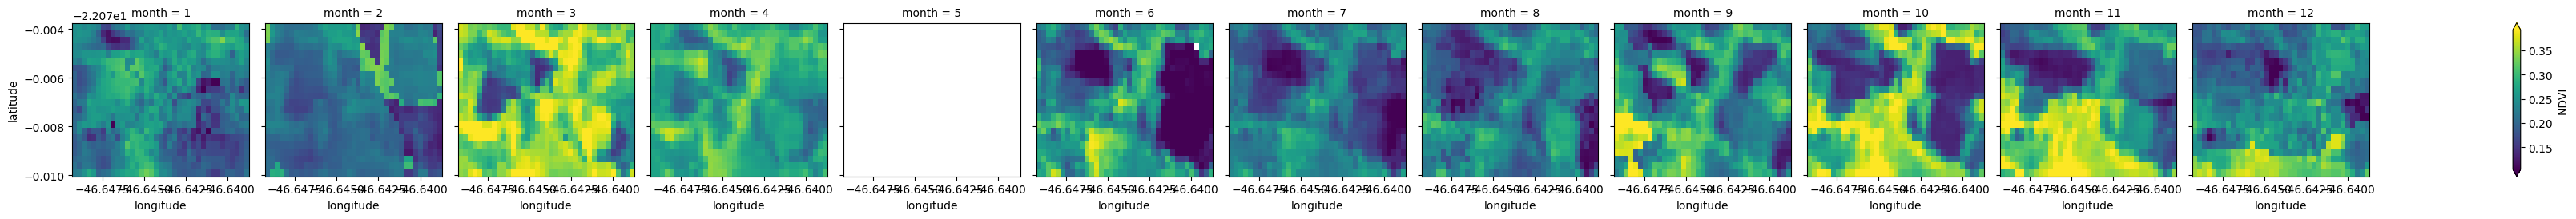

In [6]:
ndvi.groupby('time.month').mean(dim='time').plot.imshow(col='month', robust=True)

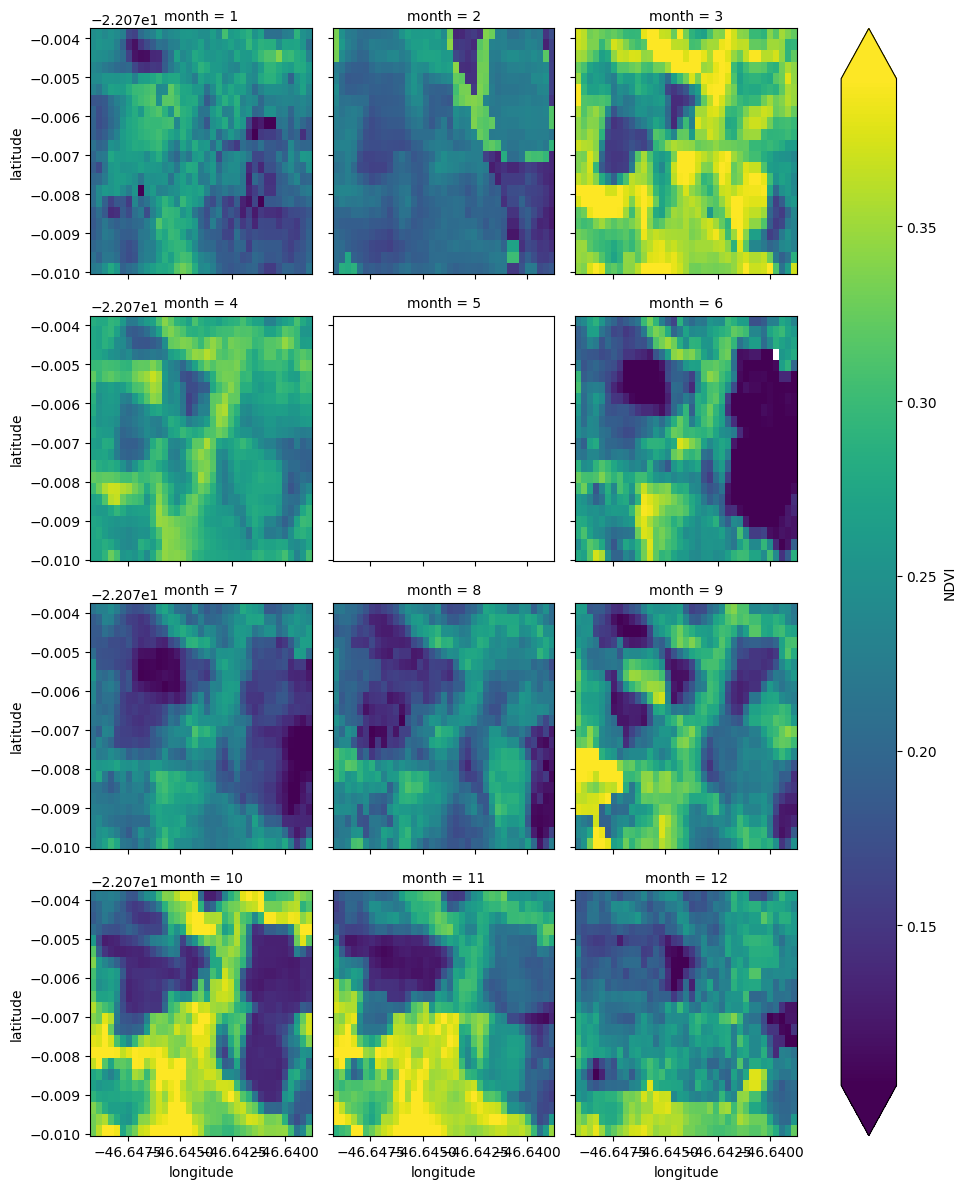

In [7]:
ndvi.groupby('time.month').mean(dim='time').plot.imshow(col='month', robust=True, col_wrap = 3)

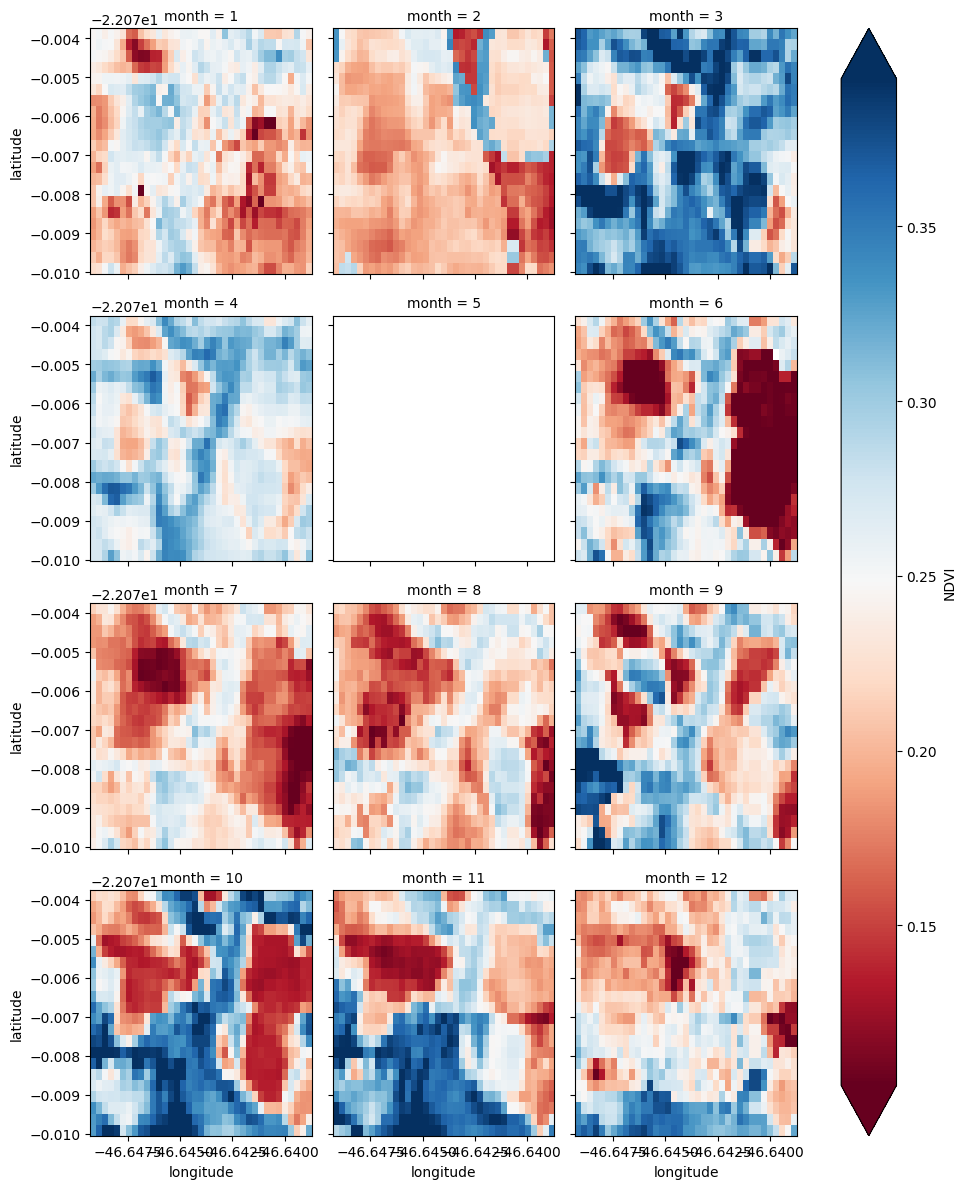

In [9]:
ndvi.groupby('time.month').mean(dim='time').plot.imshow(col='month', 
robust=True, 
col_wrap = 3,
cmap = 'RdBu')

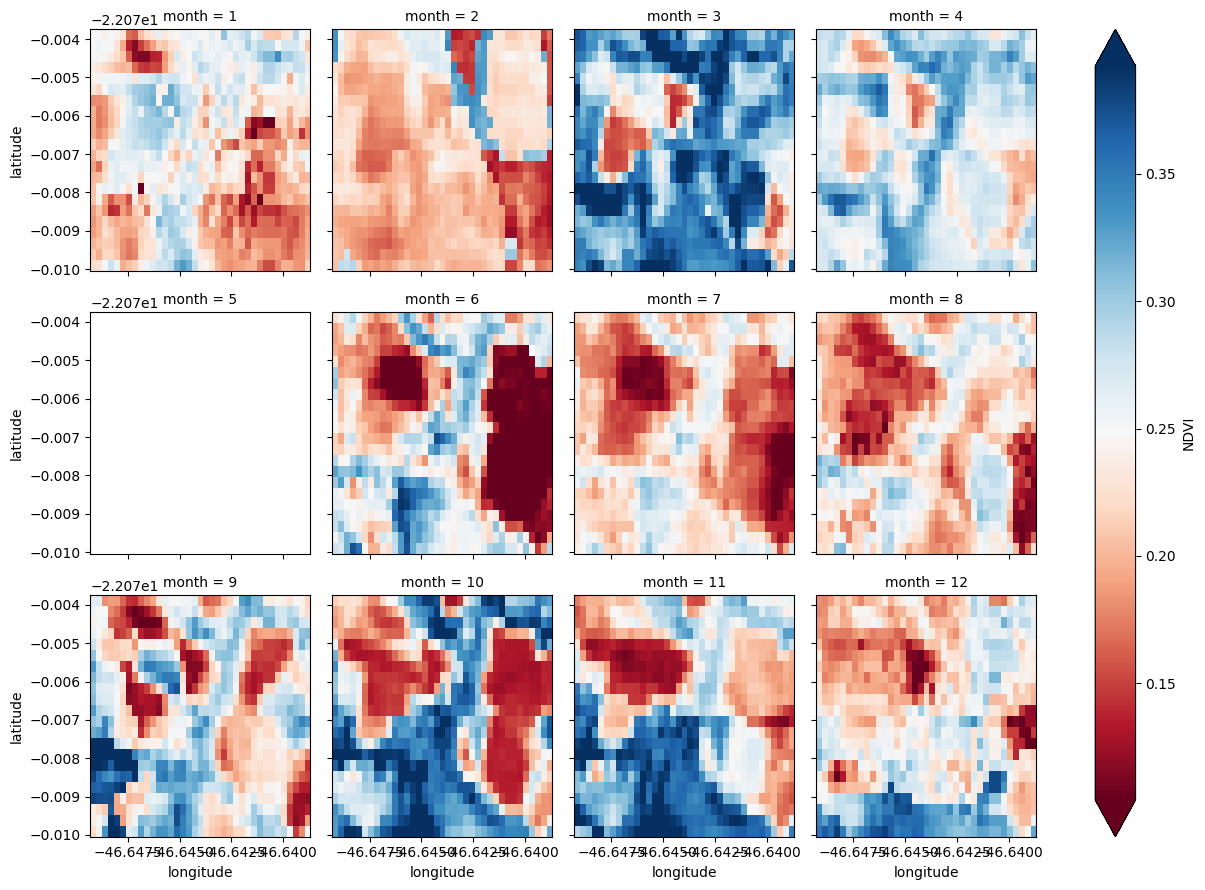

In [10]:
ndvi.groupby('time.month').mean(dim='time').plot.imshow(col='month', 
robust=True, 
col_wrap = 4,
cmap = 'RdBu')

In [11]:
run = 'f3_'
# f1 varios filtros, only L8 e L9, break em 2017
#   f1 salvando em float32

# f2 = f1 + landsat 5 e 7
#  tentar try except:

farm_file = '/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/CAR.gpkg'
folder_nc = farm_file.split('CAR.gpkg')[0] + f'nc/{run}/'
print(folder_nc)

import os
import boto3
import rasterio as rio
from pystac_client import Client
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
from datetime import date, datetime

from utils import *
import matplotlib.pyplot as plt

# Set environment and create AWS Session
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
os.environ['AWS_REQUEST_PAYER'] = 'requester'

print("Creating AWS Session")
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)
print(aws_session)

# open Farm
farm = gpd.read_file(farm_file, layer='AREA_IMOVEL_1')
bbox = get_bbox(farm)

#  Satellite imagery query params
today = date.today()
datetime_rangefull = str(f"2023-06-20/{str(today)}") #break  2017
max_cloud = 100
#bucketname = 'sanca'
satellite = 'Landsat'

/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f3_/
Creating AWS Session


In [12]:
URL = 'https://landsatlook.usgs.gov/stac-server'
cat = Client.open(URL)
collection_id = 'landsat-c2l2-sr'
collection = cat.get_collection(collection_id)
print(collection)

query_params = {
        "eo:cloud_cover": {"lt": max_cloud},
        "platform": {"in": ["LANDSAT_5","LANDSAT_7","LANDSAT_8", "LANDSAT_9"]},
       "landsat:collection_category": { "in": ['T1']}
                }

assets = ['red', 'blue', 'nir08', 'swir16' ] #'green', 'qa_pixel'

y0 = datetime.strptime(datetime_rangefull.split('/')[0],'%Y-%m-%d').year
yf = datetime.strptime(datetime_rangefull.split('/')[1],'%Y-%m-%d').year
m0 = str(datetime.strptime(datetime_rangefull.split('/')[0],'%Y-%m-%d').month).zfill(2)
mf = str(datetime.strptime(datetime_rangefull.split('/')[1],'%Y-%m-%d').month).zfill(2)
d0 = str(datetime.strptime(datetime_rangefull.split('/')[0],'%Y-%m-%d').day).zfill(2)
df = str(datetime.strptime(datetime_rangefull.split('/')[1],'%Y-%m-%d').day).zfill(2)

<CollectionClient id=landsat-c2l2-sr>


In [13]:
Path(folder_nc).mkdir( parents = True, exist_ok = True)
for ano in range(y0,yf):
    '''
        TODO falta um globals aqui pra player com os dados
    '''

    datetime_range = f'{ano}-{m0}-{d0}/{ano+1}-{m0}-{d0}'
    if yf == (ano+1):
        datetime_range = f'{ano}-{m0}-{d0}/{ano+1}-{mf}-{df}'
    print(ano, datetime_range)

    datetime_range = '2013-06-20/2024-05-08'
    datetime_range_name = datetime_range.replace('/','_')
    try:
        ds = get_cube(datetime_range, 
                                        cat, 
                                        collection_id, 
                                        bbox, 
                                        query_params, 
                                        aws_session, assets)
        ds = dropper( ds , sat = satellite ) 

        # é aqui que a filtragem acontece
        ds2 = ds.copy()

        # valores extremos 
        ds2 = xr.where(ds2 > 40000, np.nan, ds2)
        ds2 = xr.where(ds2 < 5000, np.nan, ds2)
        for asset in assets:
            quantiles = [0.01,0.1,0.25,0.5,0.75,0.9,0.99]
            print(asset)
            print(quantiles)
            print(np.nanquantile(ds2[asset],quantiles))
            ds2[asset] = xr.where(ds2[asset] < np.nanquantile(ds2[asset],[0.01]), np.nan, ds2[asset])
            ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.99]), np.nan, ds2[asset])
            if asset == 'blue':
                ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.76]), np.nan, ds2[asset])
        
        # interpolate_na
        ds2 = ds2.chunk(dict(time=-1))
        ds2 = ds2.interpolate_na(dim="time",
                method='linear',
                use_coordinate=True, 
            ) 

        # rolling
        w = 3
        ds2 = ds2.rolling(time=w, center=True).mean(skipna=True)


        # REPROJECTION
        print(f'reprojecting cube for {datetime_range}')
        ds2 = ds2.rio.write_crs('epsg:4326')
        ds2 = ds2.rio.reproject('EPSG:4326')
        ds2 = ds2.rename({'x': 'longitude','y': 'latitude'})
        print('reprojecting... done')


        # CALCULATE indices
        ndvi = NDVI( ds2 )
        bsi= BSI( ds2 )

        # get dates to save exact name
        t0 = str(ndvi.time[0].values).split('T')[0]
        t1 = str(ndvi.time[0].values).split('T')[0]
        n = len(ndvi.time)
        try:
            ndvi = dropper(ndvi, 'Landsat')
            bsi = dropper(bsi, 'Landsat')
        except:
            print('not dropping, probably wont save')
        # save nc
        ndvi.to_netcdf(f'{folder_nc}/ndvi_{t0}-{t1}_{n}.nc')
        print('> ndvi saved')
        bsi.to_netcdf(f'{folder_nc}/bsi_{t0}-{t1}_{n}.nc.nc')
        print('> bsi saved') 

        # # CALCULATE climatology
        # ndvi_mean, ndvi_std = climatology(ndvi)
        # bsi_mean, bsi_std = climatology(bsi)

        # # CALCULATE Zscore and anomalies
        # ndvi_anom, ndvi_z = zscore( ndvi, 
        #                         how = 'month')
        # bsi_anom, bsi_z = zscore( bsi, 
        #                         how = 'month')

    except:
        print(f'{datetime_range} FAILED')

# # # %%
# # ndvi.clip(0,1000)
# # # %% TEMOS UM ds


# #%% a copy
# ds2 = ds.copy(deep=True)

# for asset in assets:
#     plt.hist(np.ravel(ds2[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

# ts = ds2.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')
# for asset in assets:
#     plt.plot(ts[asset].values, label = asset)

# #%% filta os principais outliers
# ds2 = ds.copy(deep=True)
# ds2 = xr.where(ds2 > 40000, np.nan, ds2)
# ds2 = xr.where(ds2 < 5000, np.nan, ds2)

# for asset in assets:
#     quantiles = [0.01,0.1,0.25,0.5,0.75,0.9,0.99]
#     print(quantiles)
#     print(np.nanquantile(ds2[asset],quantiles))
#     ds2[asset] = xr.where(ds2[asset] < np.nanquantile(ds2[asset],[0.01]), np.nan, ds2[asset])
#     ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.99]), np.nan, ds2[asset])
#     if asset == 'blue':
#         ds2[asset] = xr.where(ds2[asset] > np.nanquantile(ds2[asset],[0.76]), np.nan, ds2[asset])
#         #ds2[asset] = xr.where(ds2[asset] < np.nanquantile(ds2[asset],[0.01]), np.nan, ds2[asset])
#     plt.hist((np).ravel(ds2[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

# # farm.centroid
# ts2 = ds2.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')
# for asset in assets:
#     plt.plot(ts2[asset].values, label = asset)
# plt.legend()
# plt.grid()


# # %% 
# #f -> Interpolate NaN
# #ds3 = ds2.copy()
# method = 'linear'
# ds3 = ds2.interpolate_na(dim="time",
#             method=method,
#             use_coordinate=True, 
#         ) # pchip  # limit = 7, use_coordinate=True,


# ts3 = ds3.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')

# for asset in assets:
#     plt.plot(ts3[asset].values, label = asset)
# plt.grid();plt.show();plt.close()

# for asset in assets:
#     plt.hist(np.ravel(ds3[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

# # %% 
# # f -> rolling
# w = 3
# ds4 = ds3.rolling(time=w, center=True).mean(skipna=True)#savgol_filter, window=w, polyorder=2
# ts4 = ds4.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')

# for asset in assets:
#     plt.plot(ts4[asset].values, label = asset)
    
# plt.grid();plt.show();plt.close()

# for asset in assets:
#     plt.hist(np.ravel(ds4[asset].values), bins = 100)
#     plt.title(asset); plt.grid();plt.show(); plt.close()
# # %% 
# for asset in assets:
#     plt.hist(np.ravel(ds4[asset].values), bins = 100)
#     plt.title(asset)
#     plt.show(); plt.close()
# ts2 = ds3.sel(longitude = -46.64329, latitude = -22.07701, method = 'nearest')

# for asset in assets:
#     plt.plot(ts2[asset].values, label = asset)
# plt.legend()
# plt.grid()

# for asset in assets:
#     plt.hist(np.ravel(ds4[asset].values), bins = 100)
#     plt.title(asset)
#     plt.title(asset); plt.grid();plt.show(); plt.close()

2023 2023-06-20/2024-05-08
491 items found 
 ---


/home/mariano/geo/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<<< landsat:correction dropped
<<< landsat:wrs_path dropped
<<< landsat:wrs_row dropped
<<< landsat:cloud_cover_land dropped
<<< landsat:collection_number dropped
<<< landsat:wrs_type dropped
<<< instruments dropped
--- raster:bands was not here
<<< eo:cloud_cover dropped
spec attribute deleted
red
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[ 7953.  8713.  9335. 10419. 12542. 18350. 35742.]
blue
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[ 7423.    8042.    8323.    8774.    9579.   16759.   36975.83]
nir08
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[11682.75 15440.   17002.   19066.   21975.25 26955.5  37562.25]
swir16
[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
[ 9733.   12777.   14074.   15860.   18366.   21486.   29210.58]
reprojecting cube for 2013-06-20/2024-05-08
reprojecting... done
--- landsat:correction was not here
--- landsat:wrs_path was not here
--- landsat:wrs_row was not here
--- landsat:cloud_cover_land was not here
--- landsat:collection_number was not here
--- landsat:wrs_type wa

In [14]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:                       (time: 491, y: 23, x: 35)
Coordinates: (12/21)
  * time                          (time) datetime64[ns] 4kB 2013-06-21T12:59:...
    id                            (time) <U43 84kB 'LE07_L2SP_219075_20130621...
  * x                             (x) float64 280B -46.65 -46.65 ... -46.64
  * y                             (y) float64 184B -22.07 -22.07 ... -22.08
    accuracy:geometric_rmse       (time) float64 4kB 4.59 5.408 ... 5.065 5.035
    accuracy:geometric_x_bias     int64 8B 0
    ...                            ...
    accuracy:geometric_x_stddev   (time) object 4kB 2.956 3.773 ... 3.555 3.499
    accuracy:geometric_y_stddev   (time) float64 4kB 3.511 3.874 ... 3.609 3.62
    proj:epsg                     int64 8B 32623
    landsat:scene_id              (time) <U21 41kB 'LE72190752013172CUB00' .....
    view:sun_azimuth              (time) float64 4kB 36.26 35.36 ... 42.8 40.26
    epsg                          int64 8B 4326
Data variables:
    red                           (time, y, x) uint16 791kB dask.array<chunksize=(1, 23, 35), meta=np.ndarray>
    blue                          (time, y, x) uint16 791kB dask.array<chunksize=(1, 23, 35), meta=np.ndarray>
    nir08                         (time, y, x) uint16 791kB dask.array<chunksize=(1, 23, 35), meta=np.ndarray>
    swir16                        (time, y, x) uint16 791kB dask.array<chunksize=(1, 23, 35), meta=np.ndarray>
Attributes:
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-46.65|\n| 0.00,-0.00,-22.07|\n| 0.00, 0.00,...
    resolution_xy:  (0.0002911701437469105, 0.0002739262060451608)

In [15]:
ndvi

<xarray.DataArray 'NDVI' (time: 491, latitude: 22, longitude: 36)> Size: 2MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan, 0.27886674],
        [0.2637785 , 0.26441845, 0.3128767 , ...,        nan,
                nan,        nan],
        [0.23663668, 0.24343744, 0.29373008, ...,        nan,
                nan,        nan],
...
        [0.27159122, 0.28455085, 0.26286831, ..., 0.2561738 ,
         0.29919153, 0.29973653],
        [0.2659442 , 0.27119732, 0.29042697, ..., 0.25023252,
         0.24823911, 0.2581277 ],
        [0.26750392, 0.27324697, 0.29281887, ..., 0.28027624,
         0.23541747, 0.26843637]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates: (12/22)
  * longitude                     (longitude) float64 288B -46.65 ... -46.64
  * latitude                      (latitude) float64 176B -22.07 ... -22.08
    accuracy:geometric_rmse       (time) float64 4kB 4.59 5.408 ... 5.065 5.035
  * time                          (time) datetime64[ns] 4kB 2013-06-21T12:59:...
    accuracy:geometric_x_bias     int64 8B 0
    card4l:specification          <U2 8B 'SR'
    ...                            ...
    view:off_nadir                int64 8B 0
    epsg                          int64 8B 4326
    proj:epsg                     int64 8B 32623
    landsat:scene_id              (time) <U21 41kB 'LE72190752013172CUB00' .....
    view:sun_azimuth              (time) float64 4kB 36.26 35.36 ... 42.8 40.26
    spatial_ref                   int64 8B 0

In [16]:
bsi

<xarray.DataArray 'BSI' (time: 491, latitude: 22, longitude: 36)> Size: 2MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.0417836 , -0.03398362, -0.01277849, ...,         nan,
         -0.03795129, -0.04046331],
        [-0.01729389, -0.03568939, -0.04332317, ...,         nan,
         -0.00843985,         nan],
        [-0.006297  , -0.03513168, -0.0604009 , ..., -0.04133655,
          0.00266892, -0.03073436]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates: (12/22)
  * longitude                     (longitude) float64 288B -46.65 ... -46.64
  * latitude                      (latitude) float64 176B -22.07 ... -22.08
    accuracy:geometric_rmse       (time) float64 4kB 4.59 5.408 ... 5.065 5.035
  * time                          (time) datetime64[ns] 4kB 2013-06-21T12:59:...
    accuracy:geometric_x_bias     int64 8B 0
    card4l:specification          <U2 8B 'SR'
    ...                            ...
    view:off_nadir                int64 8B 0
    epsg                          int64 8B 4326
    proj:epsg                     int64 8B 32623
    landsat:scene_id              (time) <U21 41kB 'LE72190752013172CUB00' .....
    view:sun_azimuth              (time) float64 4kB 36.26 35.36 ... 42.8 40.26
    spatial_ref                   int64 8B 0

In [17]:

def zscore( ds , how = 'month' ):
    '''
        Calculate zscores 
    '''
    if how == 'month':
        timeformat = "%Y-%m"
        timelabel = "year_month"
    if how == 'week':
        timeformat = "%Y-%W"
        timelabel = 'year_week'

    print('computing ...')
    ds = ds.assign_coords(year_month=ds.time.dt.strftime(timeformat))
    ds_anom = ds.groupby(timelabel) - ds.groupby(timelabel).mean("time")
    ds_z = ds_anom.groupby(timelabel) / ds.groupby(timelabel).std("time")
   
    ds_anom.compute()
    ds_z.compute()
    print('computing ... done')
    return ds_anom, ds_z


def climatology( ds ):
    '''

    '''
    ds_mean = ds.groupby("time.month").mean("time")
    ds_std = ds.groupby("time.month").std("time")
    return ds_mean, ds_std

In [18]:
ndvi_a,ndvi_z = zscore( ndvi)

computing ...
computing ... done


/home/mariano/geo/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mariano/geo/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [19]:
t0 = str(ndvi_z.time[0].values).split('T')[0]
t1 = str(ndvi_z.time[-1].values).split('T')[0]
n = len(ndvi_z.time)

ndvi_z.to_netcdf(f'{folder_nc}/ndvi_z_{t0}-{t1}_{n}.nc')

ValueError: unable to infer dtype on variable 'accuracy:geometric_x_stddev'; object array contains mixed native types: int, float

In [20]:
t0 = str(ndvi_z.time[0].values).split('T')[0]
t1 = str(ndvi_z.time[-1].values).split('T')[0]
n = len(ndvi_z.time)

ndvi_z = dropper(ndvi_z, sat = 'Landsat')
ndvi_z.to_netcdf(f'{folder_nc}/ndvi_z_{t0}-{t1}_{n}.nc')

--- landsat:correction was not here
--- landsat:wrs_path was not here
--- landsat:wrs_row was not here
--- landsat:cloud_cover_land was not here
--- landsat:collection_number was not here
--- landsat:wrs_type was not here
--- instruments was not here
--- raster:bands was not here
--- eo:cloud_cover was not here
no attribute spec to remove


ValueError: unable to infer dtype on variable 'accuracy:geometric_x_stddev'; object array contains mixed native types: int, float

In [21]:
ndvi_z.time

<xarray.DataArray 'time' (time: 491)> Size: 4kB
array(['2013-06-21T12:59:35.028396000', '2013-06-29T13:05:55.255744000',
       '2013-07-07T12:59:24.007022000', ..., '2024-04-16T13:03:49.289032000',
       '2024-04-24T13:03:24.700636000', '2024-05-02T13:03:33.299209000'],
      dtype='datetime64[ns]')
Coordinates: (12/21)
    accuracy:geometric_rmse       (time) float64 4kB 4.59 5.408 ... 5.065 5.035
  * time                          (time) datetime64[ns] 4kB 2013-06-21T12:59:...
    accuracy:geometric_x_bias     (time) int64 4kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    card4l:specification          (time) <U2 4kB 'SR' 'SR' 'SR' ... 'SR' 'SR'
    accuracy:geometric_y_bias     (time) int64 4kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    card4l:specification_version  (time) <U3 6kB '5.0' '5.0' ... '5.0' '5.0'
    ...                            ...
    epsg                          (time) int64 4kB 4326 4326 4326 ... 4326 4326
    proj:epsg                     (time) int64 4kB 32623 32623 ... 32623 32623
    landsat:scene_id              (time) <U21 41kB 'LE72190752013172CUB00' .....
    view:sun_azimuth              (time) float64 4kB 36.26 35.36 ... 42.8 40.26
    spatial_ref                   (time) int64 4kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    year_month                    (time) object 4kB '2013-06' ... '2024-05'

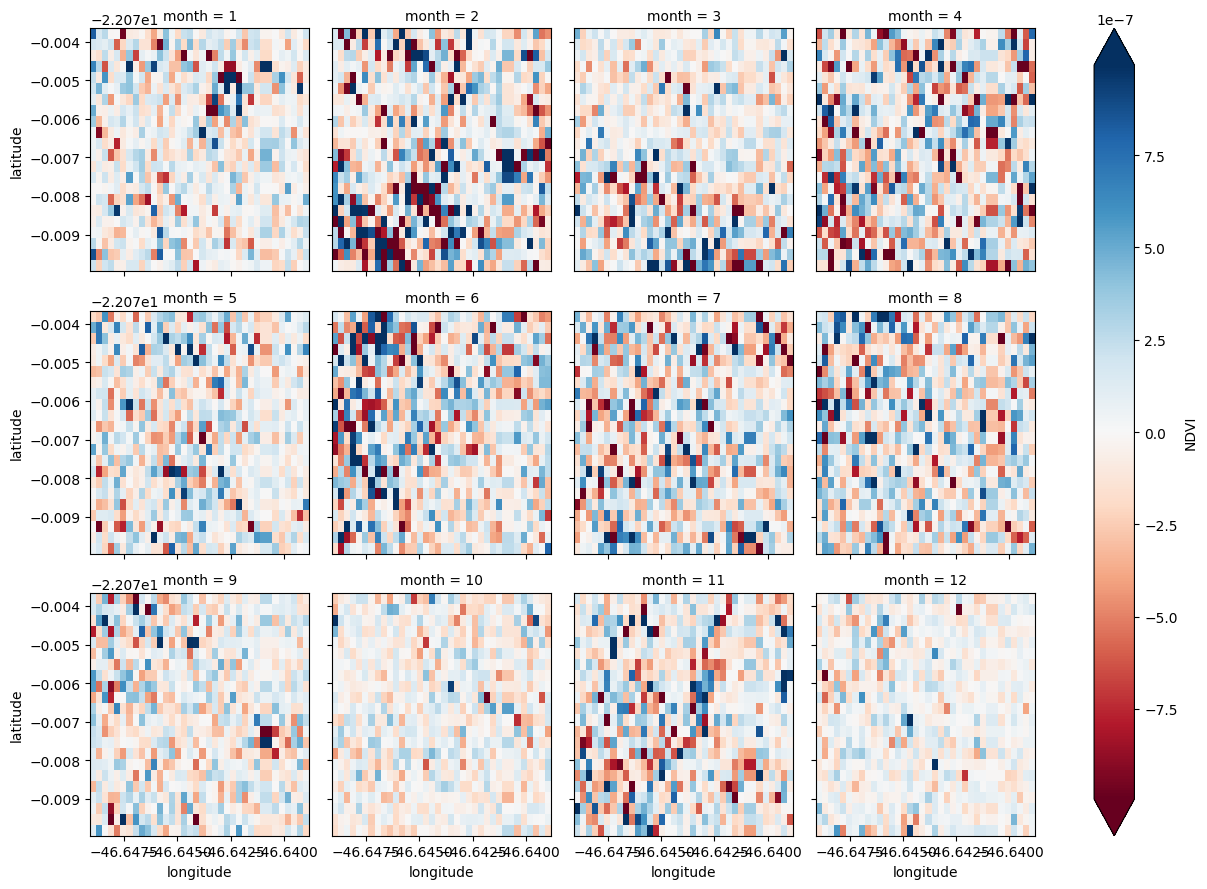

In [22]:
ndvi_z.groupby('time.month').mean(dim='time').plot.imshow(col='month', 
robust=True, 
col_wrap = 4,
cmap = 'RdBu')

In [25]:
ndvi_z.groupby('year_month').mean(dim='time').plot.imshow(col='month', 
robust=True, 
col_wrap = 4,
cmap = 'RdBu')

KeyError: 'month'

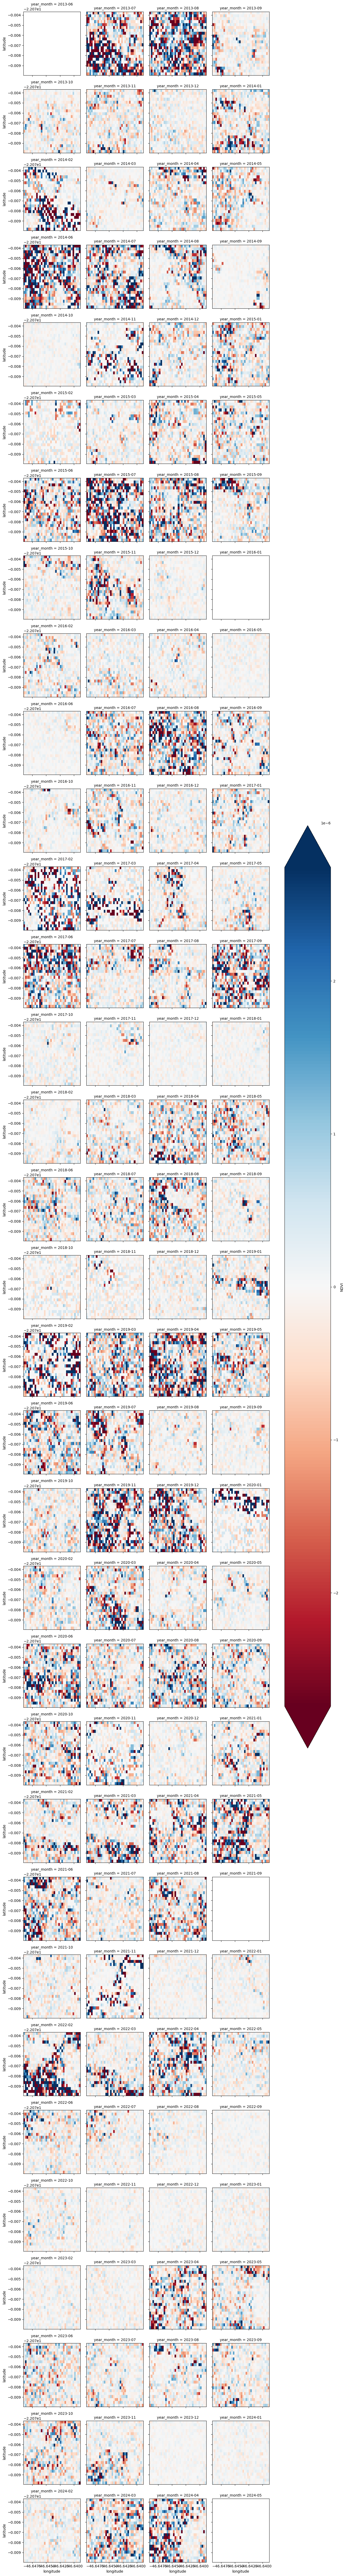

In [26]:
ndvi_z.groupby('year_month').mean(dim='time').plot.imshow(col='year_month', 
robust=True, 
col_wrap = 4,
cmap = 'RdBu')

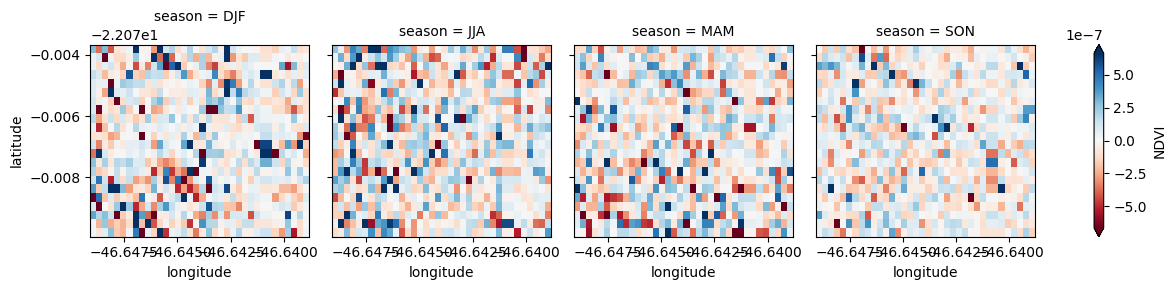

In [30]:
ndvi_z.groupby('time.season').mean(dim='time').plot.imshow(col='season', 
robust=True, 
col_wrap = 4,
cmap = 'RdBu')

In [32]:
import pandas as pd

In [35]:
ndvi_z_m = ndvi_z.groupby('year_month').mean(dim='time')

In [41]:

def dropper( ds, sat = 'Landsat' ):
    '''
        Drop vars
        TODO drop attrs e.g. 'spec'
    '''

    if sat == 'Landsat':
        drops = ['landsat:correction','landsat:wrs_path',
                 'landsat:wrs_row','landsat:cloud_cover_land',
                    'landsat:collection_number','landsat:wrs_type','instruments',
                    'raster:bands','eo:cloud_cover','accuracy:geometric_x_stddev'
                    ]
        
    # if sat == 'Sentinel':
    #    drops
    
    for d in drops:
        try:
            ds = ds.drop_vars(d)
            print(f'<<< {d} dropped')
        except:
            print(f'--- {d} was not here')
    try:
        del ds.attrs['spec']
        print('spec attribute deleted')
    except:
        print('no attribute spec to remove')

    return ds

In [42]:
ndvi_z = dropper(ndvi_z, 'Landsat')

--- landsat:correction was not here
--- landsat:wrs_path was not here
--- landsat:wrs_row was not here
--- landsat:cloud_cover_land was not here
--- landsat:collection_number was not here
--- landsat:wrs_type was not here
--- instruments was not here
--- raster:bands was not here
--- eo:cloud_cover was not here
<<< accuracy:geometric_x_stddev dropped
no attribute spec to remove


In [43]:
ndvi_z.to_netcdf(f'{folder_nc}/ndviz.nc')

In [44]:
ndvi_z_m = ndvi_z.groupby('year_month').mean(dim='time')

In [45]:
ndvi_z_m = ndvi_z.groupby('year_month').mean(dim='time')
ndvi_z_m = dropper(ndvi_z_m, 'Landsat')
ndvi_z_m.to_netcdf(f'{folder_nc}/ndvizm.nc')

--- landsat:correction was not here
--- landsat:wrs_path was not here
--- landsat:wrs_row was not here
--- landsat:cloud_cover_land was not here
--- landsat:collection_number was not here
--- landsat:wrs_type was not here
--- instruments was not here
--- raster:bands was not here
--- eo:cloud_cover was not here
--- accuracy:geometric_x_stddev was not here
no attribute spec to remove


In [46]:
ndvi_z.resample('ME').max()

ValueError: the first argument to .resample must be a dictionary

In [47]:
ndvi_z.resample(time='ME').max()

<xarray.DataArray 'NDVI' (time: 132, latitude: 22, longitude: 36)> Size: 418kB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.7676359 , 0.77349234, 0.83344734, ..., 1.0446979 ,
         1.0631044 , 1.1207783 ],
        [0.8735439 , 0.92451483, 0.78685725, ..., 0.9923137 ,
         1.074913  , 1.0708901 ],
        [1.3903108 , 1.0266294 , 0.7171625 , ..., 1.0100583 ,
         1.1317511 , 0.99522436],
...
        [1.2560477 , 1.2217458 , 1.1806605 , ..., 1.3045954 ,
         1.3749602 , 1.2822394 ],
        [1.3922844 , 1.3301992 , 1.0579993 , ..., 0.8199736 ,
         1.2046372 , 1.2539755 ],
        [1.4034497 , 1.1932398 , 1.1155967 , ..., 1.4140326 ,
         0.93889916, 1.3973231 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 288B -46.65 -46.65 -46.65 ... -46.64 -46.64
  * latitude   (latitude) float64 176B -22.07 -22.07 -22.07 ... -22.08 -22.08
  * time       (time) datetime64[ns] 1kB 2013-06-30 2013-07-31 ... 2024-05-31

In [48]:
ndvi_z.resample(time='ME').mean()

<xarray.DataArray 'NDVI' (time: 132, latitude: 22, longitude: 36)> Size: 418kB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[ 1.9470851e-06,  0.0000000e+00,  6.3578290e-07, ...,
         -1.1920929e-06, -1.6689301e-06,  0.0000000e+00],
        [-1.5099844e-06,  1.5099844e-06,  2.6226044e-06, ...,
         -2.0265579e-06,  0.0000000e+00, -7.9472858e-07],
        [-7.6293945e-06, -2.5828679e-06,  3.9736431e-08, ...,
          0.0000000e+00, -8.3446503e-07, -1.0728836e-06],
...
        [ 3.5663445e-06, -2.3047130e-06,  6.7949295e-06, ...,
          7.5499219e-07, -8.7420148e-07,  0.0000000e+00],
        [-1.9868216e-08, -4.9670539e-09,  1.5099844e-06, ...,
          1.9868216e-08,  1.9470851e-06, -1.2318293e-06],
        [ 1.9868216e-08,  0.0000000e+00, -2.5729339e-06, ...,
         -1.7881393e-06, -1.3907751e-06,  1.3510386e-06]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 288B -46.65 -46.65 -46.65 ... -46.64 -46.64
  * latitude   (latitude) float64 176B -22.07 -22.07 -22.07 ... -22.08 -22.08
  * time       (time) datetime64[ns] 1kB 2013-06-30 2013-07-31 ... 2024-05-31

In [49]:
ndvi_z.resample(time='ME').mean().to_netcdf(f'{folder_nc}/ndvizm.nc')

In [50]:
ndvi_z.resample(time='ME').mean(skipna=True).to_netcdf(f'{folder_nc}/ndvizm.nc')

In [56]:
np.nanquantile(ndvi_zm,[0.01,0.25,0.5,0.75,0.9,0.99])

print('max')
ndvi_zm = ndvi_z.resample(time='ME').max(skipna=True)
np.nanquantile(ndvi_zm,[0.01,0.25,0.5,0.75,0.9,0.99])

print('mean')
ndvi_zm = ndvi_z.resample(time='ME').mean(skipna=True)
np.nanquantile(ndvi_zm,[0.01,0.25,0.5,0.75,0.9,0.99])

print('min')
ndvi_zm = ndvi_z.resample(time='ME').min(skipna=True)
np.nanquantile(ndvi_zm,[0.01,0.25,0.5,0.75,0.9,0.99])

max
mean
min


array([-1.89142849, -1.41071928, -1.25190532, -1.00095749, -0.90309031,
       -0.71125397])

In [58]:
ndvi_z2 = xr.where(ndvi_z > 3, np.nan, ndvi_z)
ndvi_z2 = xr.where(ndvi_z < -3, np.nan, ndvi_z)

In [59]:
ndvi_z2 = ndvi_z2.interpolate_na(dim="time",
                method='linear',
                use_coordinate=True, 
            ) 

In [64]:
ndvi_zm = ndvi_z2.resample(time='ME').median(skipna=True)

In [65]:
ndvi_zm = ndvi_z2.resample(time='ME').median(skipna=True)
ndvi_zm..to_netcdf(f'{folder_nc}/ndvizMEmedian.nc')

SyntaxError: invalid syntax (<ipython-input-65-76ef0986dcae>, line 2)

In [66]:
ndvi_zm = ndvi_z2.resample(time='ME').median(skipna=True)
ndvi_zm.to_netcdf(f'{folder_nc}/ndvizMEmedian.nc')

In [67]:

print('median')
ndvi_zm = ndvi_z2.resample(time='ME').median(skipna=True)
print(np.nanquantile(ndvi_zm,[0.01,0.25,0.5,0.75,0.9,0.99]))

median
[-0.68879206 -0.2150093   0.          0.26569325  0.49084226  0.69284215]
